<a href="https://colab.research.google.com/github/IvanKatorgin/Time-series/blob/main/%D0%92%D1%80%D0%B5%D0%BC%D0%B5%D0%BD%D0%BD%D1%8B%D0%B5_%D1%80%D1%8F%D0%B4%D1%8B_%D0%B4%D0%BE%D0%BC%D0%B0%D1%88%D0%BD%D0%B5%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Курс "Временные ряды". Домашнее задание 3. Модели ARMA. Каторгин И.П.

Описание задания:
1. Выберите ряд из первого задания.
2. Постройте его модель ARIMA.
3. Оформите отчёт в Jupyter-ноутбук.

Дополнительное задание*

Попробуйте спрогнозировать график классическим ML

In [305]:
# загрузим библиотеки
import numpy as np, pandas as pd, seaborn as sns, matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tqdm
from scipy.stats import boxcox
from scipy.optimize import minimize
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa import ar_model
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score, median_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression

In [4]:
!pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.1/985.1 kB 13.5 MB/s eta 0:00:00


In [5]:
from arch import arch_model

In [306]:
# загрузим данные
female_births = pd.read_csv('daily-total-female-births-in-cal.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
airlines_passengers = pd.read_csv('international-airline-passengers.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
mean_monthly_temp = pd.read_csv('mean-monthly-air-temperature-deg.csv', sep = ',', header = 0, encoding = 'utf-8')['Deg']
robberies_in_boston = pd.read_csv('monthly-boston-armed-robberies-j.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
sales_of_company_x = pd.read_csv('monthly-sales-of-company-x-jan-6.csv', sep = ',', header = 0, encoding = 'utf-8')['Count']
dowjones_closing = pd.read_csv('weekly-closings-of-the-dowjones-.csv', sep = ',', header = 0, encoding = 'utf-8')['Close']

In [307]:
all_series = {
    "Monthly sales of company X": sales_of_company_x,
    "Monthly Boston armed robberies": robberies_in_boston,
    "International airline passengers: monthly totals in thousands": airlines_passengers,
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp,
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing,
    "Daily total female births in California": female_births
}

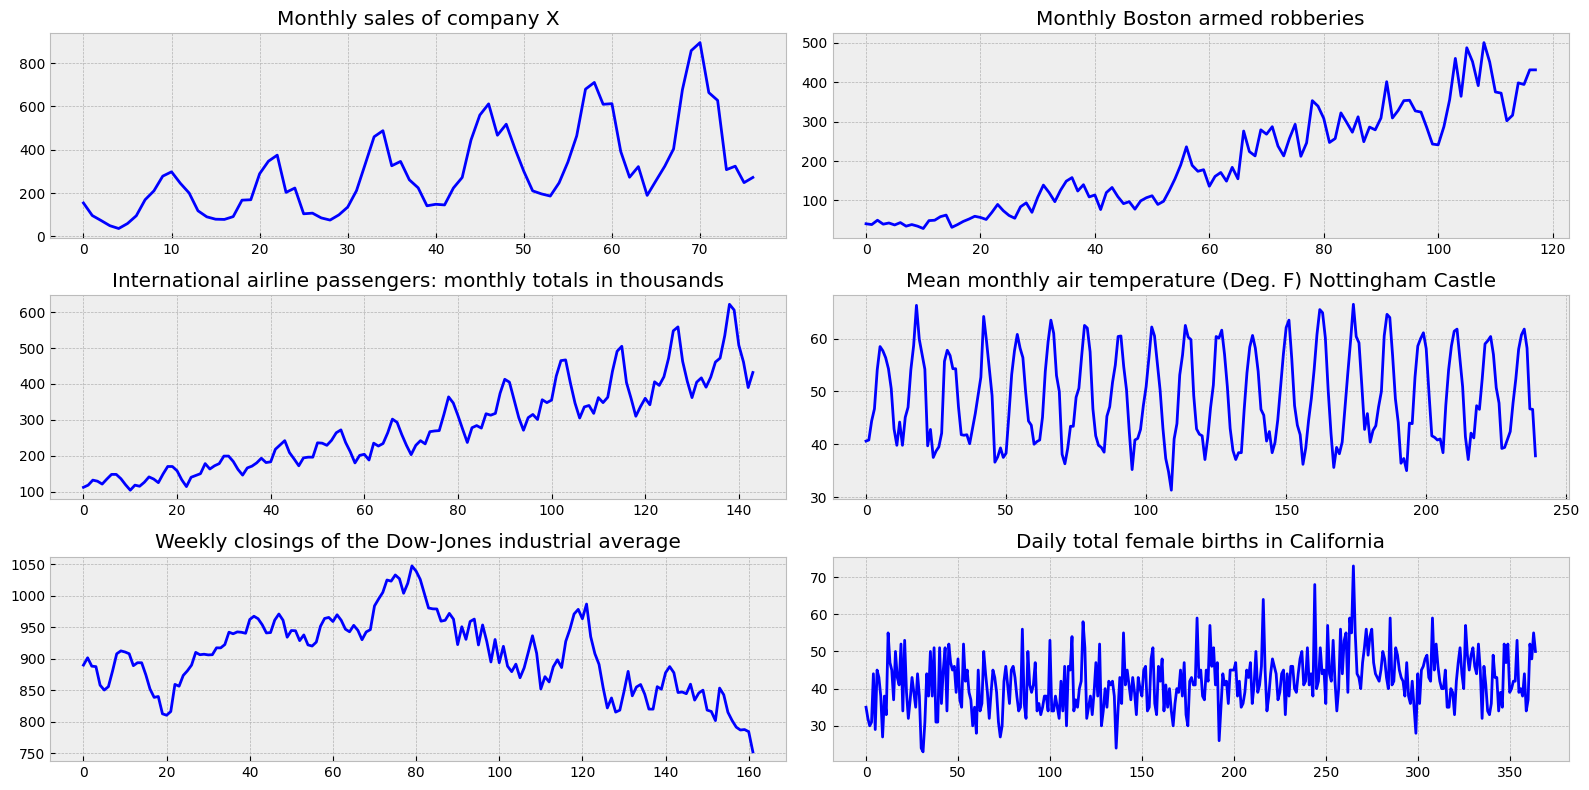

In [308]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

Из домашнего задания 1 мы знаем, что ряд "Daily total female births in California" - стационарный, остальные - нет.

Сначала построим модель ARIMA на стационарном ряду, потом на нестационарном

Для построения моделей понадобятся несколько функций ниже:

In [309]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [310]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

## Стационарный ряд

Белый шум и случайные блуждания

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


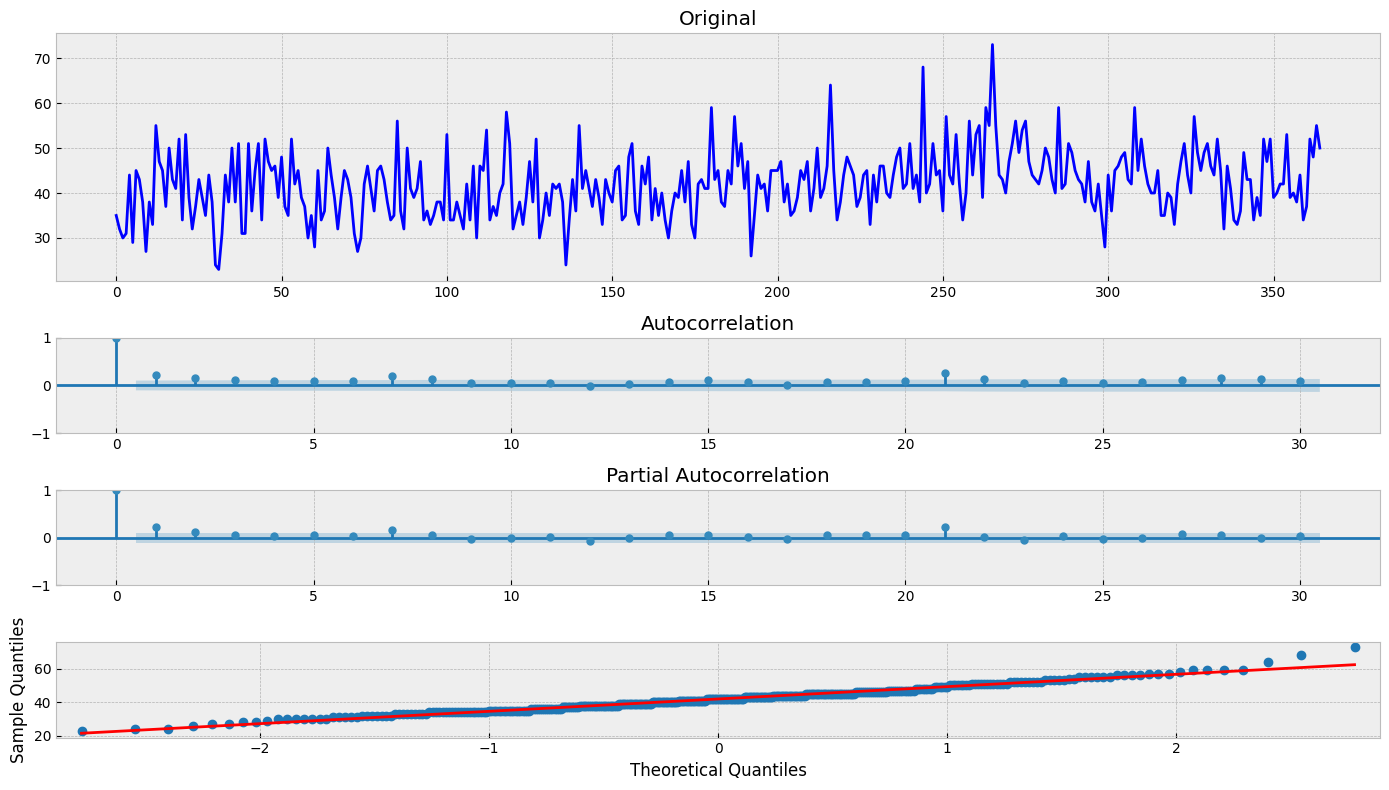

In [311]:
# возьмем ряд daily_total_female_births_in_california
tsplot(female_births, lags=30)

 Проверим, подходит ли модель случайного блуждания под наш ряд. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

Results of Dickey-Fuller Test:
Test Statistic                -1.262518e+01
p-value                        1.547240e-23
#Lags Used                     6.000000e+00
Number of Observations Used    3.570000e+02
Critical Value (1%)           -3.448801e+00
Critical Value (5%)           -2.869670e+00
Critical Value (10%)          -2.571101e+00
dtype: float64


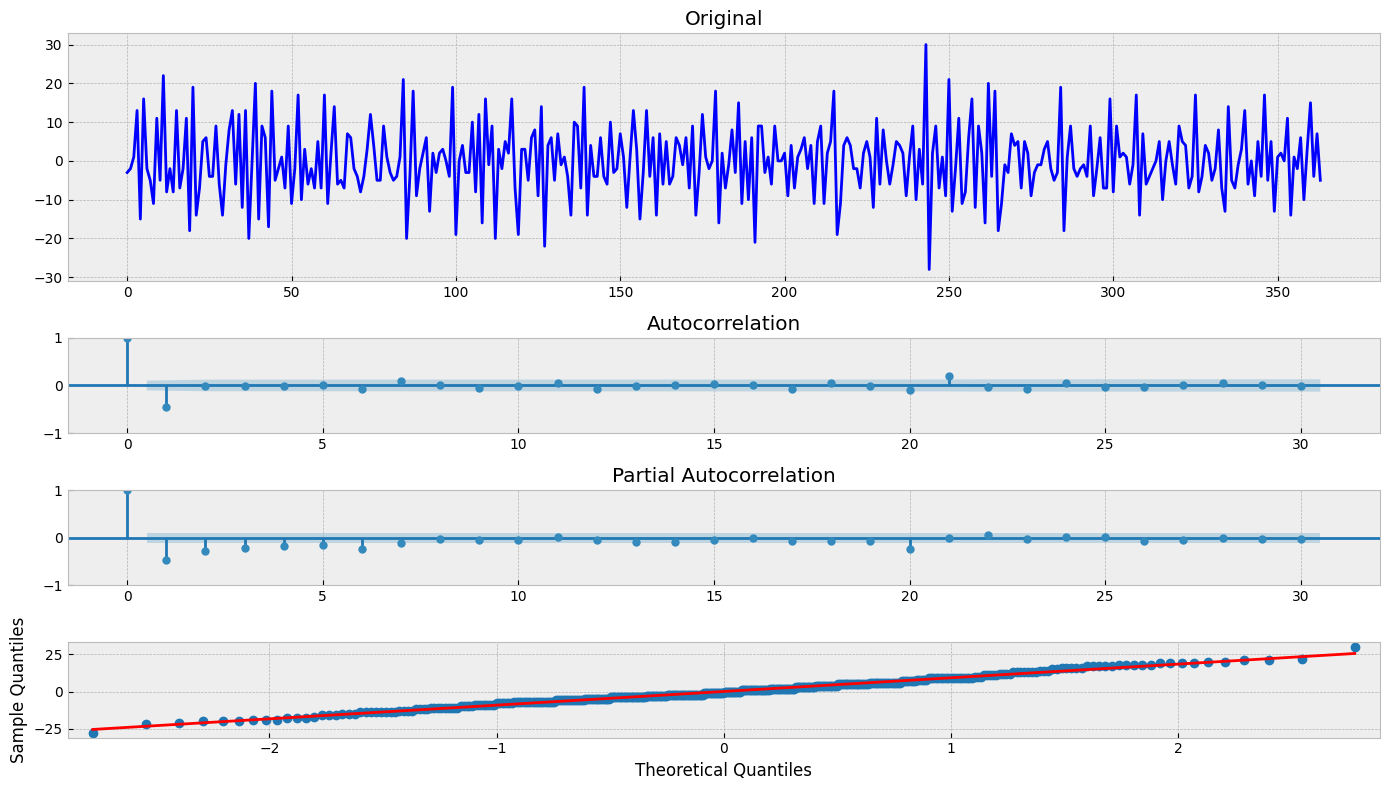

In [312]:
tsplot(np.diff(female_births), lags=30)

В целом наш ряд подходит под модель случайного блуждания

Теперь проверим гипотезу авторегрессионной модели на том же самом ряду

In [313]:
# построим модель авторегрессии
mdl = AutoReg(female_births, lags=30, trend='n').fit()
est_order = ar_select_order(female_births, maxlag=30, trend='n')

print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order.ar_lags[0]))


alpha estimate: 0.16167 | best lag order = 1


<ipython-input-313-dfa189ba6c34>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order.ar_lags[0]))


In [314]:
mdl.params

,0
Count.L1,0.161668
Count.L2,0.085956
Count.L3,0.025448
Count.L4,0.044431
Count.L5,0.047737
Count.L6,-0.025334
Count.L7,0.150612
Count.L8,0.070396
Count.L9,-0.038110
Count.L10,0.025468


Results of Dickey-Fuller Test:
Test Statistic                -1.830970e+01
p-value                        2.277460e-30
#Lags Used                     0.000000e+00
Number of Observations Used    3.340000e+02
Critical Value (1%)           -3.450081e+00
Critical Value (5%)           -2.870233e+00
Critical Value (10%)          -2.571401e+00
dtype: float64


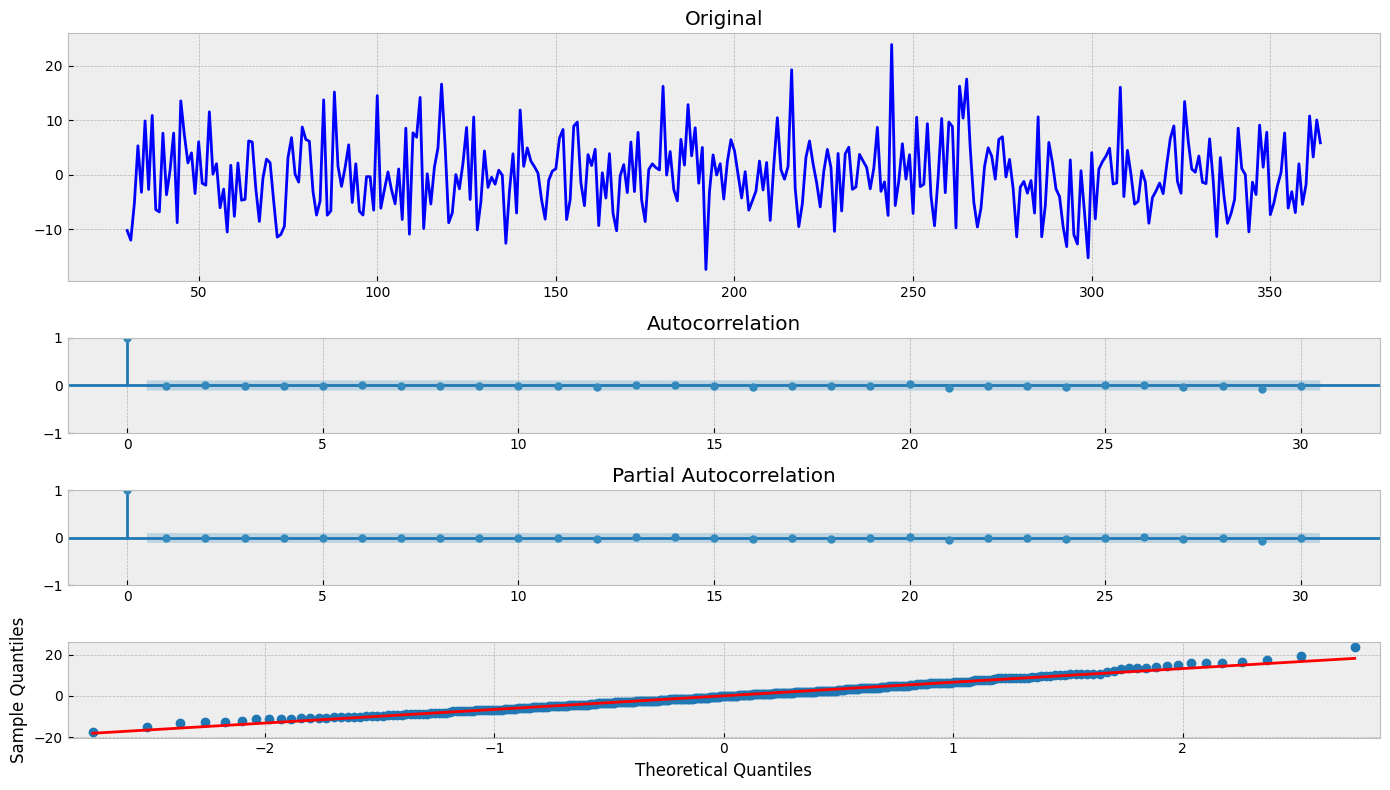

In [315]:
tsplot(mdl.resid, lags=30)

В целом ряд подходит под модель авторегрессии

Построим модель ARMA

In [316]:
# построим модель ARMA
mdl = ARIMA(female_births, order=(2, 0, 0), trend='c').fit()
print(mdl.params)
print(mdl.summary())

const     41.981587
ar.L1      0.193904
ar.L2      0.113919
sigma2    50.630084
dtype: float64
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                  365
Model:                 ARIMA(2, 0, 0)   Log Likelihood               -1234.182
Date:                Sun, 15 Dec 2024   AIC                           2476.364
Time:                        17:38:22   BIC                           2491.963
Sample:                             0   HQIC                          2482.563
                                - 365                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.9816      0.568     73.885      0.000      40.868      43.095
ar.L1          0.1939      0.055    

Results of Dickey-Fuller Test:
Test Statistic                  -4.765394
p-value                          0.000063
#Lags Used                       7.000000
Number of Observations Used    357.000000
Critical Value (1%)             -3.448801
Critical Value (5%)             -2.869670
Critical Value (10%)            -2.571101
dtype: float64


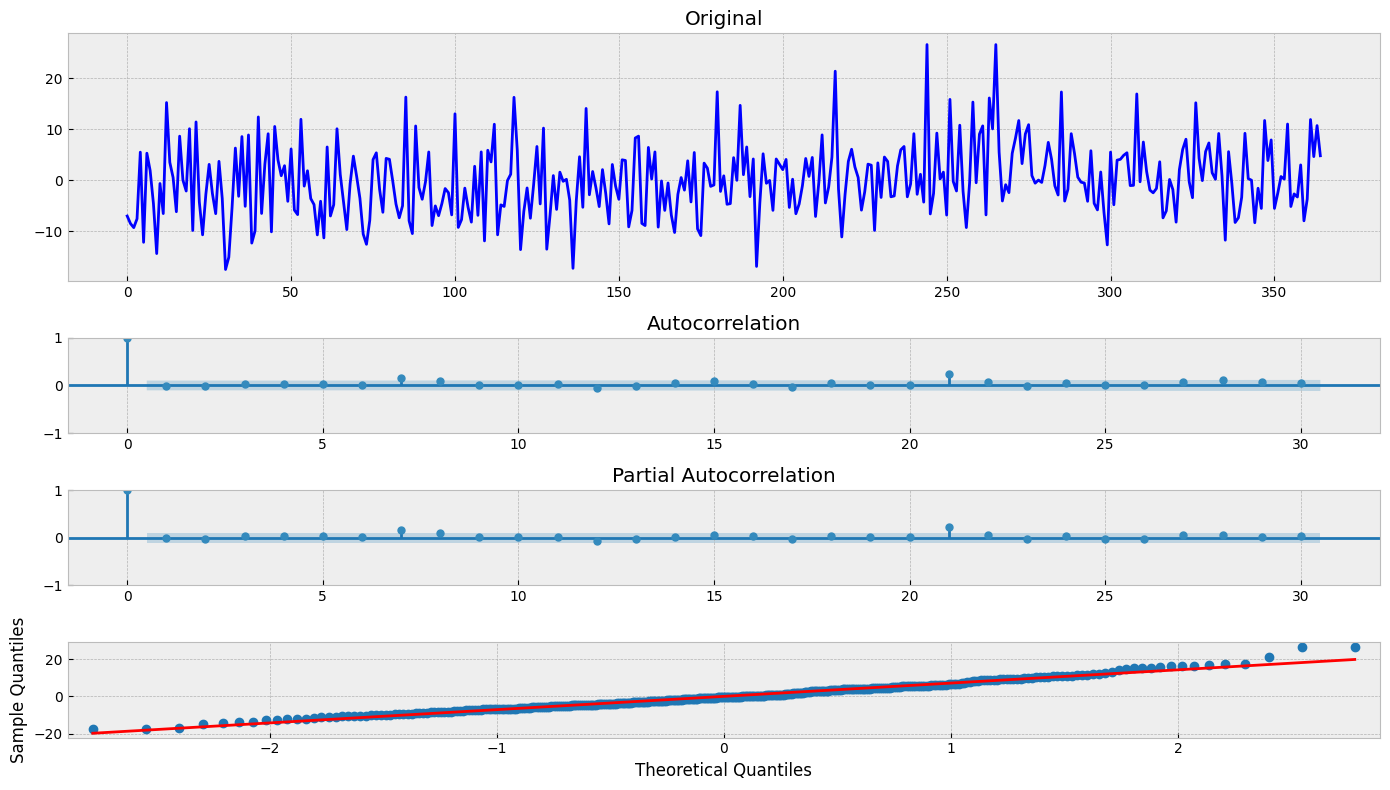

In [317]:
tsplot(mdl.resid, lags=30)

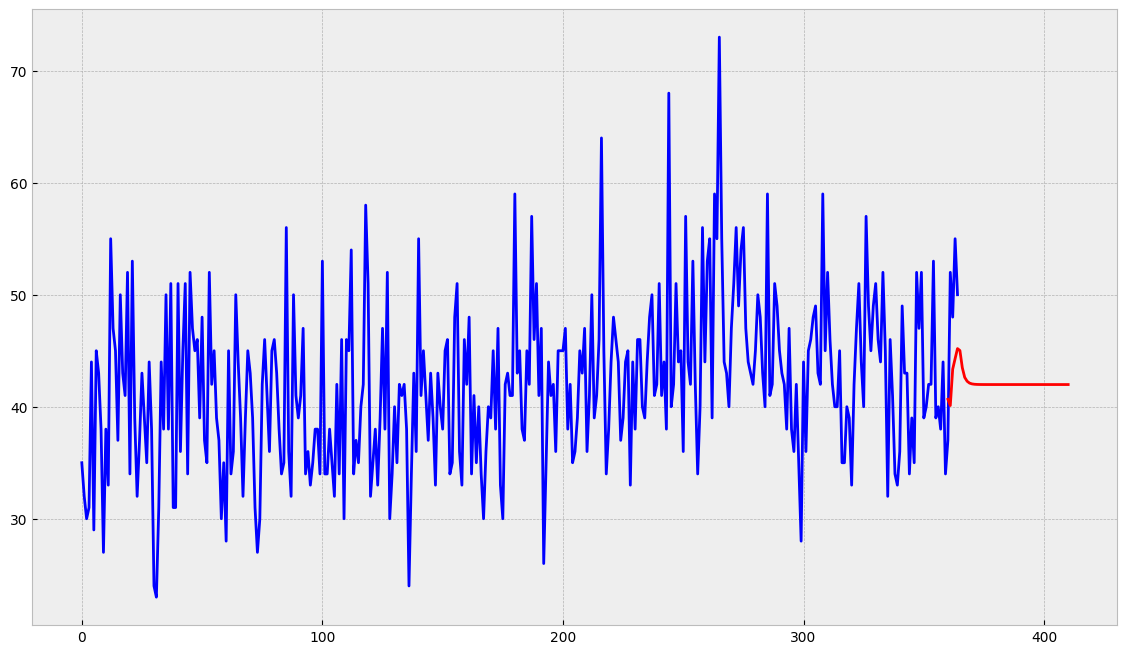

In [318]:
# сделаем предсказания
predict = mdl.predict(start=360, end=410)

with plt.style.context(style='bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    female_births.plot(ax=ax, color='blue')
    predict.plot(ax=ax, color='red')

In [319]:
mdl.aic

2476.363657107182

In [320]:
# реализуем подбор гиперпараметров модели ARMA
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = ARIMA(female_births, order=(2, 0, 0), trend='c').fit()
            tmp_aic = tmp_mdl.aic
            print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i, j)))
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 2476.36366 | order: (0, 0)
aic: 2476.36366 | order: (0, 1)
aic: 2476.36366 | order: (0, 2)
aic: 2476.36366 | order: (0, 3)
aic: 2476.36366 | order: (0, 4)
aic: 2476.36366 | order: (1, 0)
aic: 2476.36366 | order: (1, 1)
aic: 2476.36366 | order: (1, 2)
aic: 2476.36366 | order: (1, 3)
aic: 2476.36366 | order: (1, 4)
aic: 2476.36366 | order: (2, 0)
aic: 2476.36366 | order: (2, 1)
aic: 2476.36366 | order: (2, 2)
aic: 2476.36366 | order: (2, 3)
aic: 2476.36366 | order: (2, 4)
aic: 2476.36366 | order: (3, 0)
aic: 2476.36366 | order: (3, 1)
aic: 2476.36366 | order: (3, 2)
aic: 2476.36366 | order: (3, 3)
aic: 2476.36366 | order: (3, 4)
aic: 2476.36366 | order: (4, 0)
aic: 2476.36366 | order: (4, 1)
aic: 2476.36366 | order: (4, 2)
aic: 2476.36366 | order: (4, 3)
aic: 2476.36366 | order: (4, 4)
aic: 2476.36366 | order: (0, 0)


Построим модель ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

aic: 2466.28227 | order: (3, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                 -19.163527
p-value                          0.000000
#Lags Used                       0.000000
Number of Observations Used    364.000000
Critical Value (1%)             -3.448443
Critical Value (5%)             -2.869513
Critical Value (10%)            -2.571018
dtype: float64


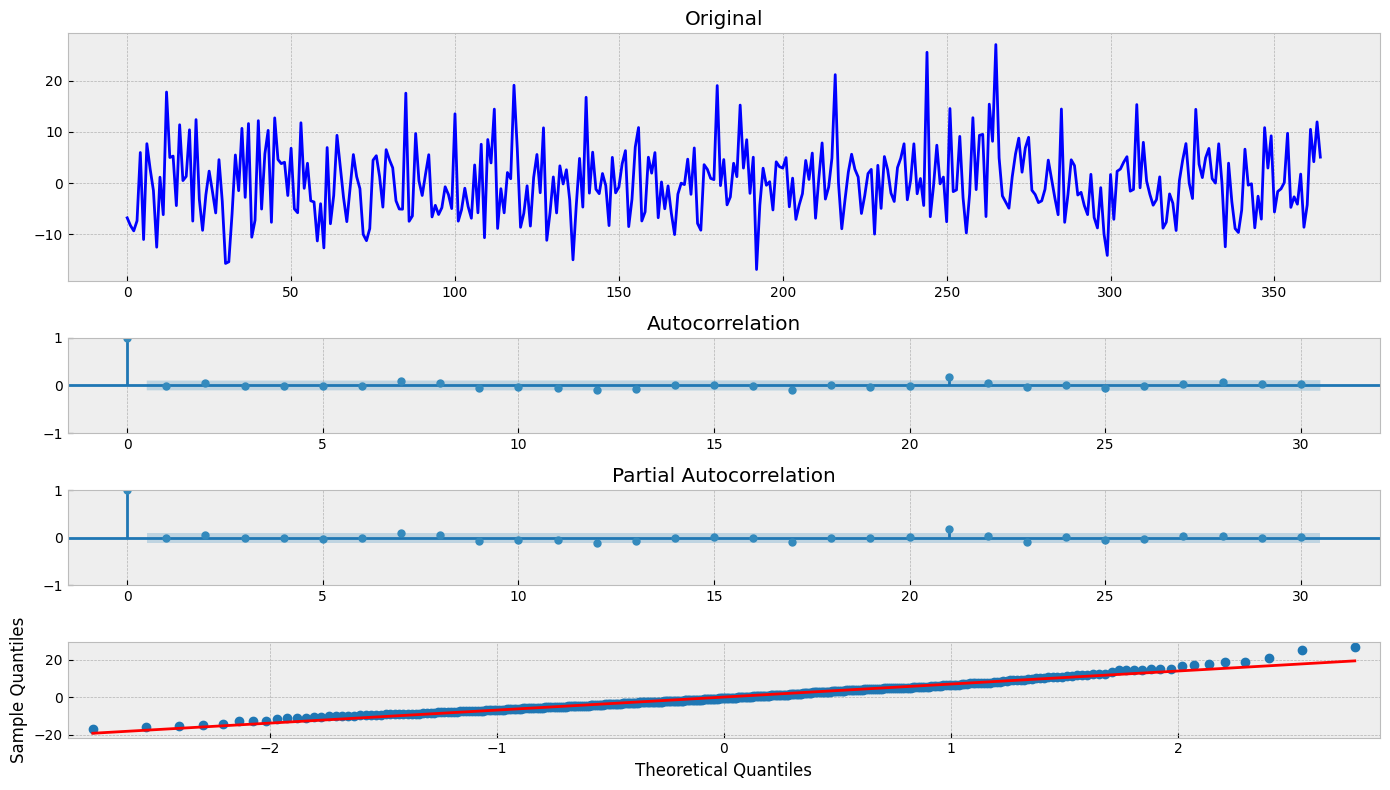

In [321]:
series = female_births

best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(female_births, order=(i,d,j), trend='c').fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=30)

In [322]:
best_mdl

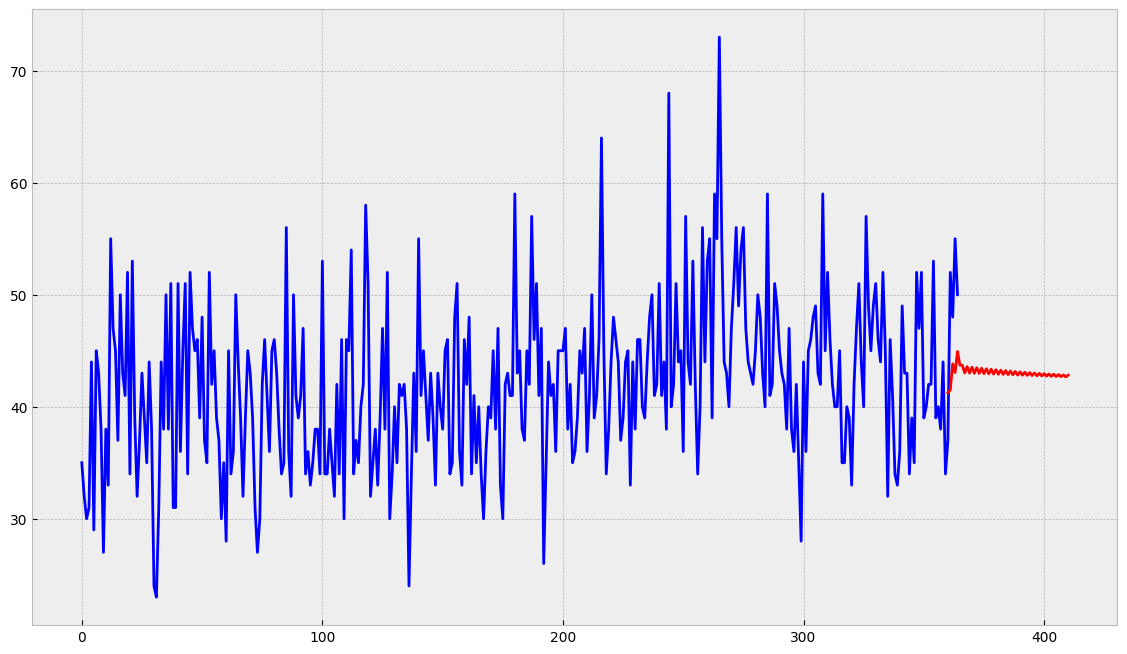

In [323]:
# сделаем прогноз
predict = best_mdl.predict(start=360, end=410)

with plt.style.context(style='bmh'):
    plt.figure(figsize=(14,8))
    ax = plt.axes()
    female_births.plot(ax=ax, color='blue')
    predict.plot(ax=ax, color='red')

Модель ARCH

In [324]:
def _get_best_model(TS):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for i in range(5):
        for d in range(5):
            for j in range(5):
                try:
                    tmp_mdl = ARIMA(TS, order=(i,d,j), trend='c').fit()
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
    return best_aic, best_order, best_mdl

aic, order, mdl = _get_best_model(series)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

aic: 2466.28227 | order: (3, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [325]:
aic, order, mdl = _get_best_model(female_births)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/st

aic: 2466.28227 | order: (3, 0, 2)


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [326]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = order[0]
o_ = order[1]
q_ = order[2]

# Using student T distribution usually provides better fit
am = arch_model(female_births, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Count   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1241.87
Distribution:      Standardized Student's t   AIC:                           2499.74
Method:                  Maximum Likelihood   BIC:                           2530.94
                                              No. Observations:                  365
Date:                      Sun, Dec 15 2024   Df Residuals:                      364
Time:                              17:40:13   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            41

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


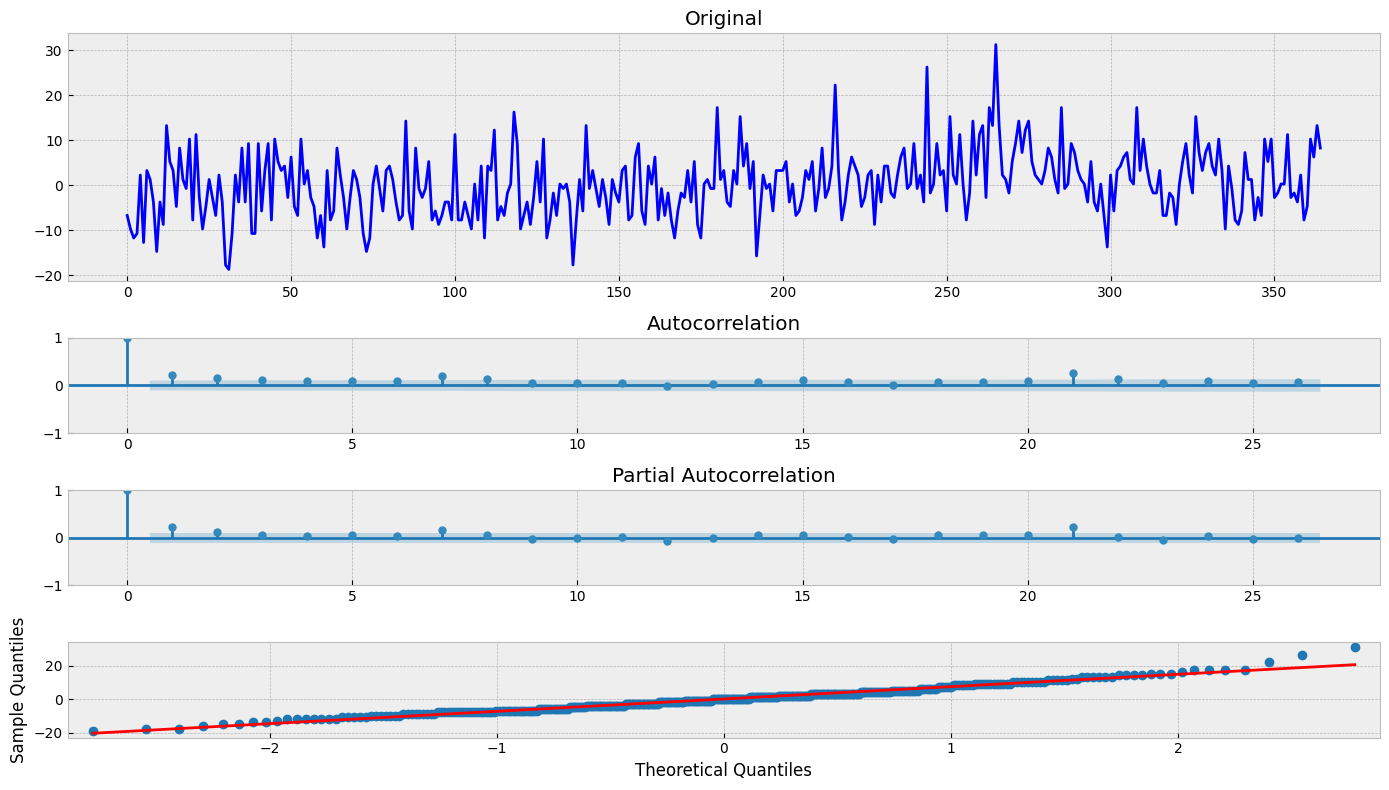

In [327]:
tsplot(res.resid)

Cпрогнозируем график классическим ML

In [328]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):

    data = pd.DataFrame(data.copy())

    # считаем индекс в датафрейме, после которого начинается тестовый отрезок
    test_index = int(len(data)*(1-test_size))

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.Count.shift(i)

    data = data.dropna()
    data = data.reset_index(drop=True)
    #data = data.drop(["Date"], axis=1)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["Count"], axis=1)
    y_train = data.loc[:test_index]["Count"]
    X_test = data.loc[test_index:].drop(["Count"], axis=1)
    y_test = data.loc[test_index:]["Count"]

    return X_train, X_test, y_train, y_test

In [329]:
X_train, X_test, y_train, y_test = prepareData(female_births, lag_start=1, lag_end=20, test_size=0.3)

In [330]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
0,41.0,43.0,50.0,37.0,45.0,47.0,55.0,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0,31.0,30.0,32.0,35.0
1,52.0,41.0,43.0,50.0,37.0,45.0,47.0,55.0,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0,31.0,30.0,32.0
2,34.0,52.0,41.0,43.0,50.0,37.0,45.0,47.0,55.0,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0,31.0,30.0
3,53.0,34.0,52.0,41.0,43.0,50.0,37.0,45.0,47.0,55.0,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0,31.0
4,39.0,53.0,34.0,52.0,41.0,43.0,50.0,37.0,45.0,47.0,55.0,33.0,38.0,27.0,38.0,43.0,45.0,29.0,44.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,40.0,43.0,44.0,55.0,73.0,55.0,59.0,39.0,55.0,53.0,44.0,56.0,40.0,34.0,42.0,53.0,42.0,44.0,57.0
252,47.0,40.0,43.0,44.0,55.0,73.0,55.0,59.0,39.0,55.0,53.0,44.0,56.0,40.0,34.0,42.0,53.0,42.0,44.0
253,51.0,47.0,40.0,43.0,44.0,55.0,73.0,55.0,59.0,39.0,55.0,53.0,44.0,56.0,40.0,34.0,42.0,53.0,42.0
254,56.0,51.0,47.0,40.0,43.0,44.0,55.0,73.0,55.0,59.0,39.0,55.0,53.0,44.0,56.0,40.0,34.0,42.0,53.0


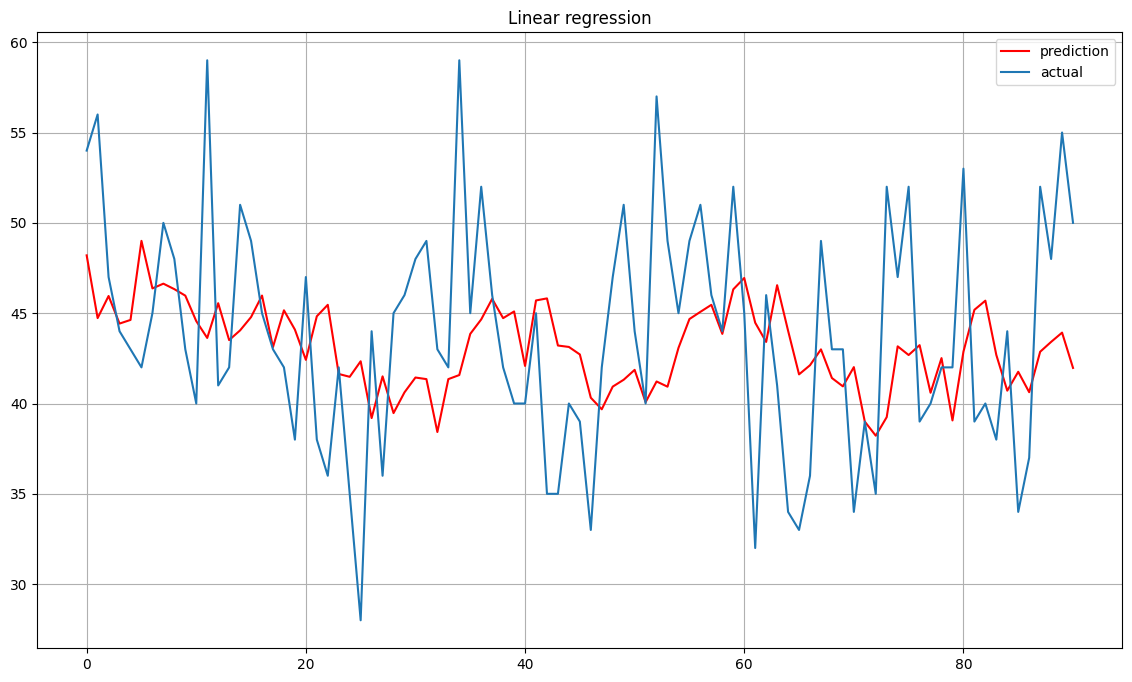

In [331]:
# Строим модель линеной регресии и график предсказания
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [332]:
# оценим качество модели
print(f"MAE: {mean_absolute_error(y_test, prediction)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
print(f"MSE: {mean_squared_error(y_test, prediction)}")
print(f"RMSE: {mean_squared_error(y_test, prediction, squared=False)}")
print(f"R2: {r2_score(y_test, prediction)}")
print(f"Explained variance score: {explained_variance_score(y_test, prediction)}")
print(f"Median absolute error: {median_absolute_error(y_test, prediction)}")

MAE: 5.230227136035676
MAPE: 0.12157341732145781
MSE: 42.48202636457451
RMSE: 6.517823744515842
R2: -0.039726853469290946
Explained variance score: -0.03053929163615865
Median absolute error: 4.589313129749158


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Отрицательное значение коэффициента R2 указывает на то, что выбранная модель не соответствует тренду данных

## Нестационарный ряд

Возьмем ряд sales_of_company_x, т.к. там есть и сезонность и тренд

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


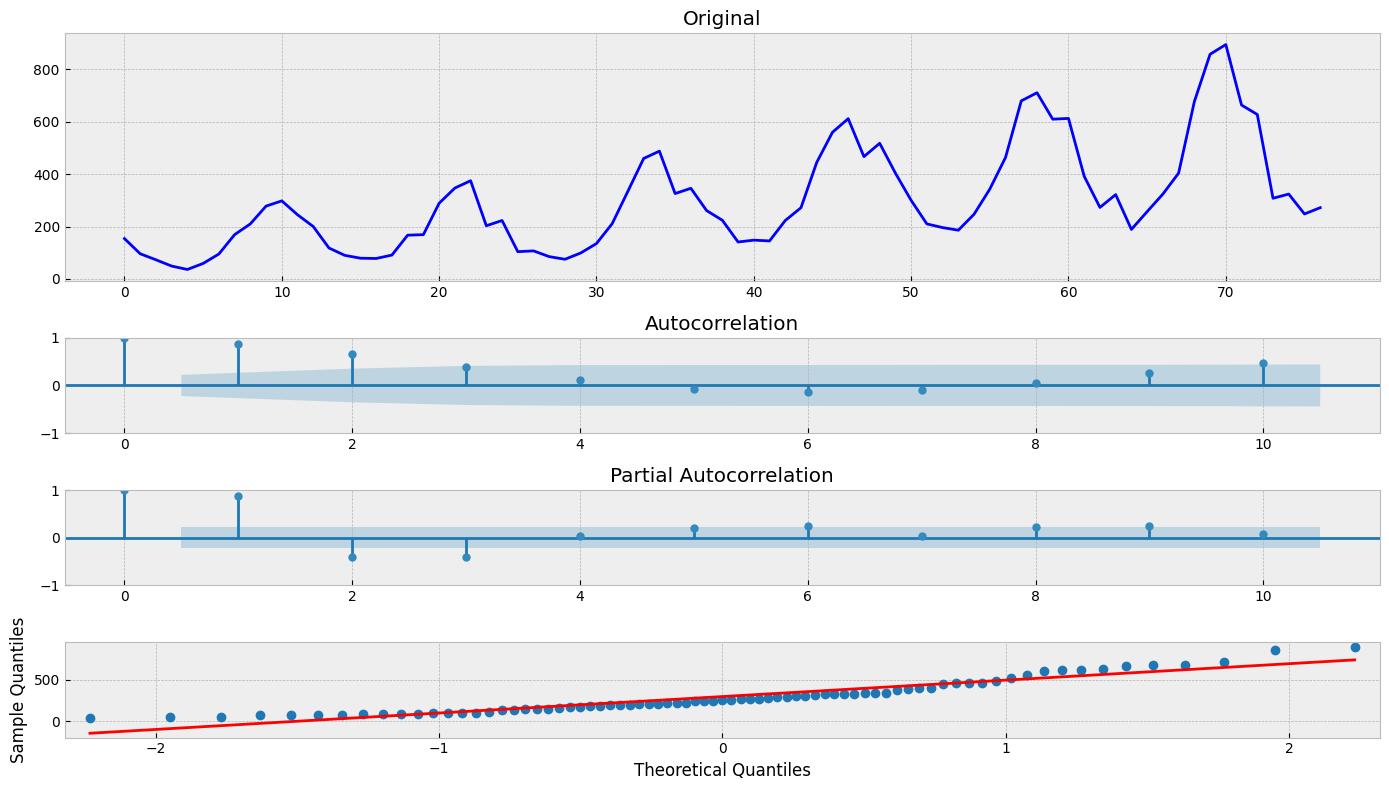

In [333]:
tsplot(sales_of_company_x, lags=10)

Уберем сезонность, тренд, разброс дисперсии

In [334]:
# функция автокорреляции
def fun_series (y, indx=1):

  total = pd.DataFrame( columns=['Lag','R'])

  for i in range(1, indx + 1):

    ser_a = pd.Series( y[:-i], name='A').reset_index(drop=True)
    ser_b =  pd.Series( y[i:], name='B').reset_index(drop=True)

    df = pd.concat([ser_a, ser_b], axis=1)

    total = pd.concat([total, pd.DataFrame( [ {'Lag': i, 'R': df.corr().at['A','B']} ] ) ])
  return total.sort_values(by='R', ascending=False).reset_index(drop=True)

In [335]:
#  определим сезонность

sezon = fun_series (series, indx=24)['Lag'][0]

print('сезонность: ', sezon)

fun_series (series, indx=24).style.background_gradient(cmap='YlOrRd',axis=0)

сезонность:  21


<ipython-input-334-86a7af7c2537>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total = pd.concat([total, pd.DataFrame( [ {'Lag': i, 'R': df.corr().at['A','B']} ] ) ])
<ipython-input-334-86a7af7c2537>:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  total = pd.concat([total, pd.DataFrame( [ {'Lag': i, 'R': df.corr().at['A','B']} ] ) ])


,Lag,R
0,21,0.281105
1,1,0.217877
2,7,0.200700
3,2,0.154437
4,22,0.149839
5,8,0.145299
6,15,0.117355
7,3,0.109906
8,20,0.098701
9,5,0.098171


In [336]:
# уберем изменение дисперсии при помощи преобразования Бокса-Кокса
series = boxcox(sales_of_company_x, 0)

#  уберем наличие тренда (дифференцирование)

series = series[1:] - series[:-1]

# Уберем влияние сезонности
series = series[sezon:] - series[:-sezon]

Results of Dickey-Fuller Test:
Test Statistic                 -1.891129
p-value                         0.336246
#Lags Used                     11.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


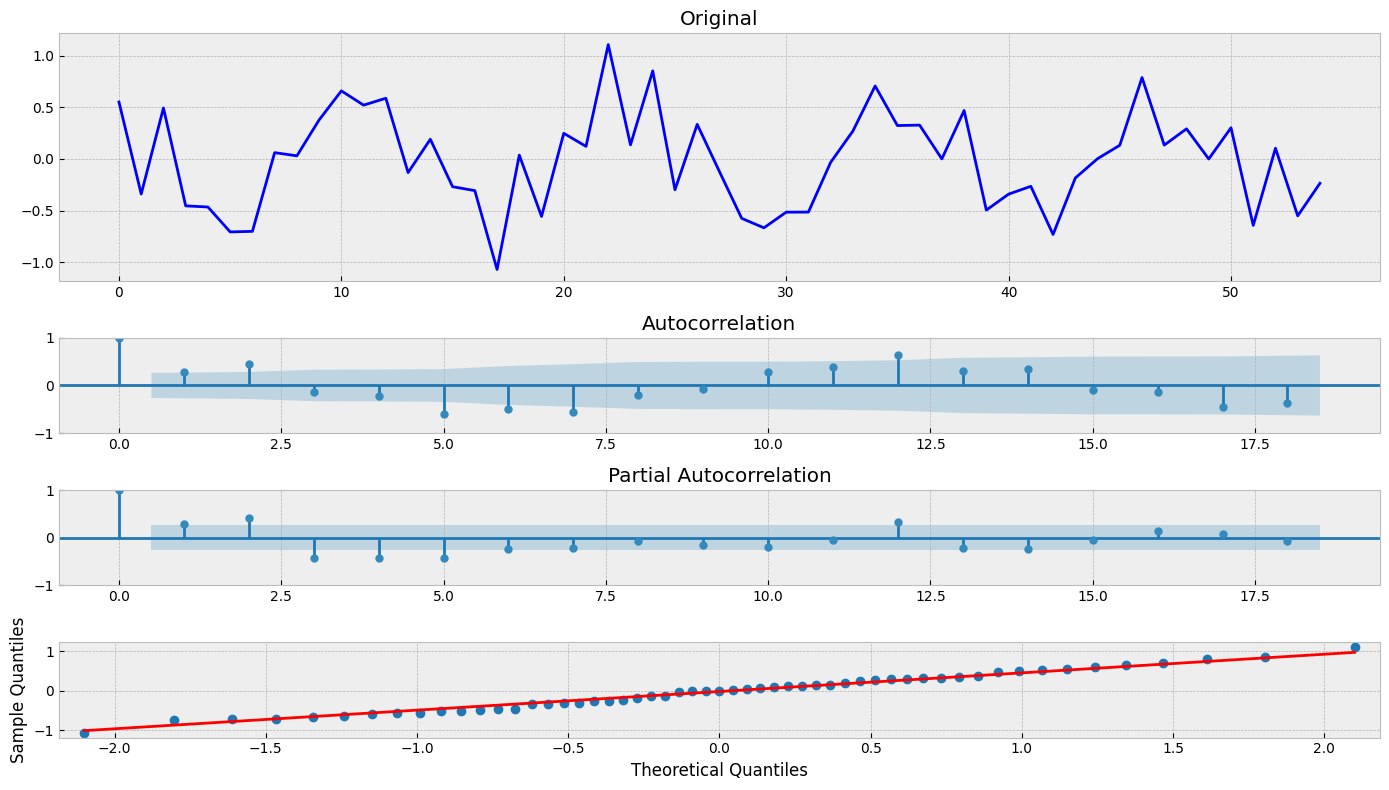

In [337]:
tsplot(series)

Теперь ряд стационарный можно строить модели

 Проверим, подходит ли модель случайного блуждания под наш ряд. Для этого надо из текущего измерения вычесть предыдущие и посмотреть остатки

Results of Dickey-Fuller Test:
Test Statistic                -7.609570e+00
p-value                        2.274051e-11
#Lags Used                     1.100000e+01
Number of Observations Used    4.200000e+01
Critical Value (1%)           -3.596636e+00
Critical Value (5%)           -2.933297e+00
Critical Value (10%)          -2.604991e+00
dtype: float64


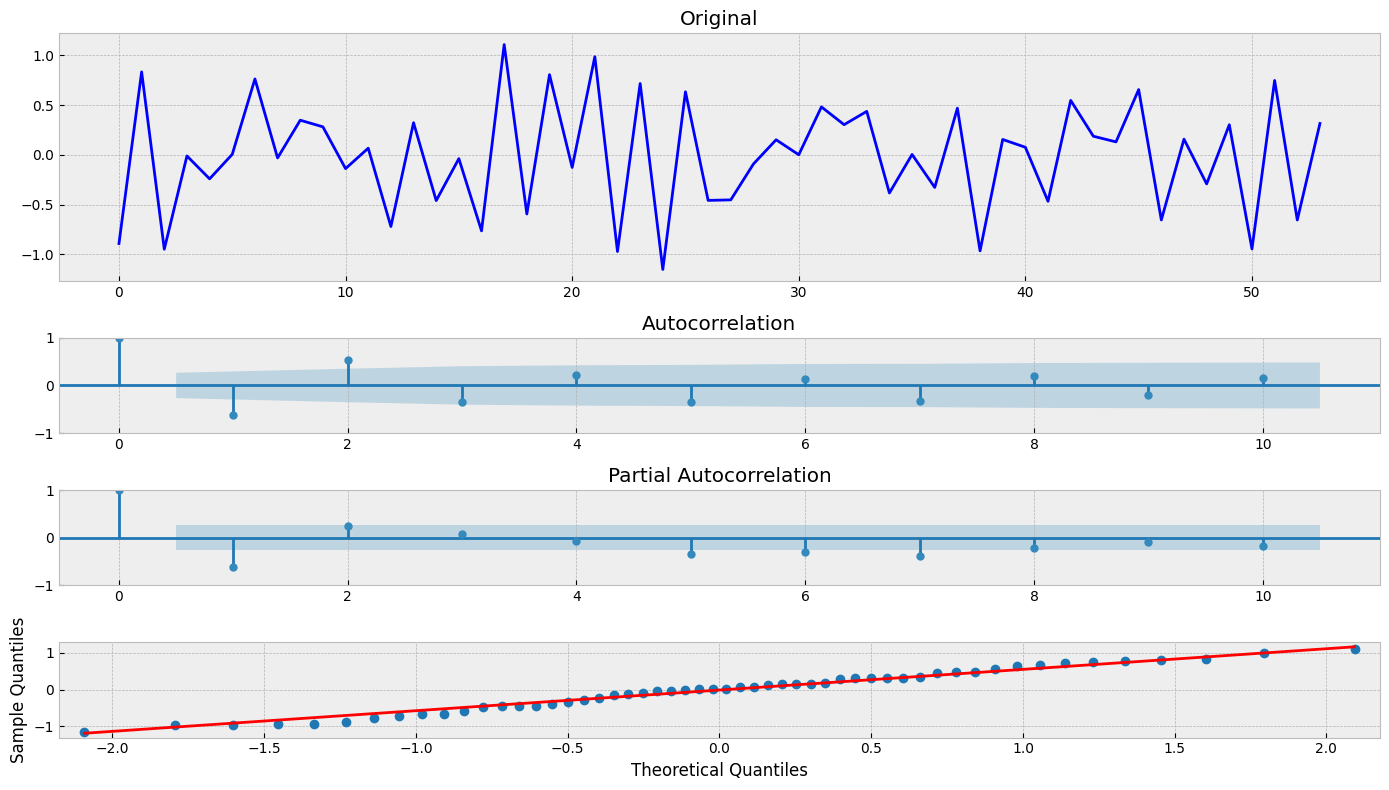

In [338]:
tsplot(np.diff(series), lags=10)

В целом наш ряд подходит под модель случайного блуждания

Теперь проверим гипотезу авторегрессионной модели на том же самом ряду

In [339]:
# построим модель авторегрессии
mdl = AutoReg(series, lags=10, trend='n').fit()
est_order = ar_select_order(series, maxlag=10, trend='n')

print('\nalpha estimate: {:3.5f} | best lag order = {}'.format(mdl.params[0], est_order.ar_lags[0]))


alpha estimate: -0.54846 | best lag order = 1


In [340]:
mdl.params

array([-0.54846033, -0.09978432, -0.316266  , -0.3237527 , -0.54082509,
       -0.43190572, -0.43849281, -0.28949715, -0.4199303 , -0.3594321 ])

Results of Dickey-Fuller Test:
Test Statistic                -6.978785e+00
p-value                        8.295289e-10
#Lags Used                     0.000000e+00
Number of Observations Used    4.400000e+01
Critical Value (1%)           -3.588573e+00
Critical Value (5%)           -2.929886e+00
Critical Value (10%)          -2.603185e+00
dtype: float64


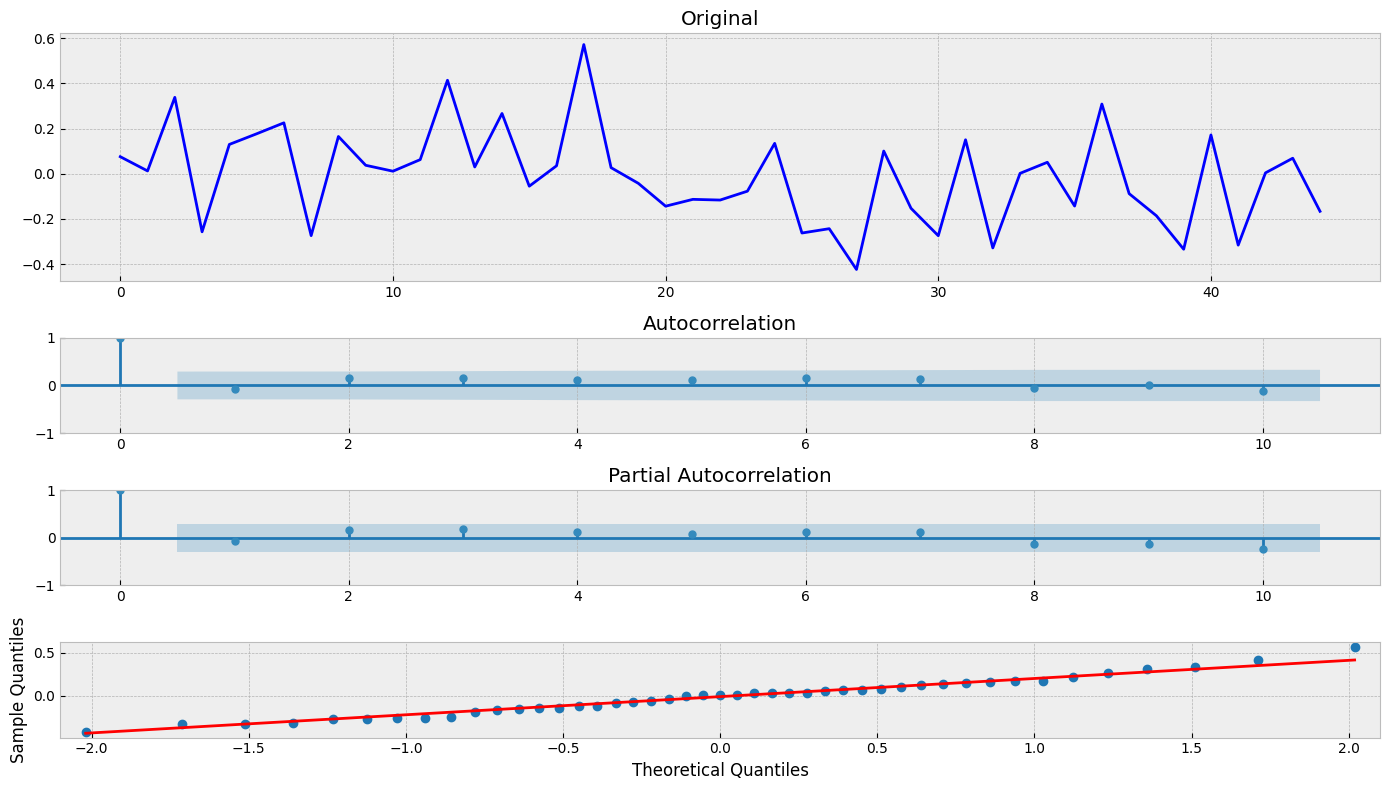

In [341]:
tsplot(mdl.resid, lags=10)

В целом ряд подходит под модель авторегрессии

Построим модель ARMA

In [342]:
# построим модель ARMA
mdl = ARIMA(series, order=(2, 0, 0), trend='c').fit()
print(mdl.params)
print(mdl.summary())

[-0.02521717  0.15766823  0.42279281  0.1660558 ]
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   55
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 -28.904
Date:                Sun, 15 Dec 2024   AIC                             65.807
Time:                        17:43:55   BIC                             73.837
Sample:                             0   HQIC                            68.912
                                 - 55                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0252      0.124     -0.203      0.839      -0.269       0.218
ar.L1          0.1577      0.146      1.081      0.280      -0.128       0.443
ar

Results of Dickey-Fuller Test:
Test Statistic                 -3.439235
p-value                         0.009692
#Lags Used                     11.000000
Number of Observations Used    43.000000
Critical Value (1%)            -3.592504
Critical Value (5%)            -2.931550
Critical Value (10%)           -2.604066
dtype: float64


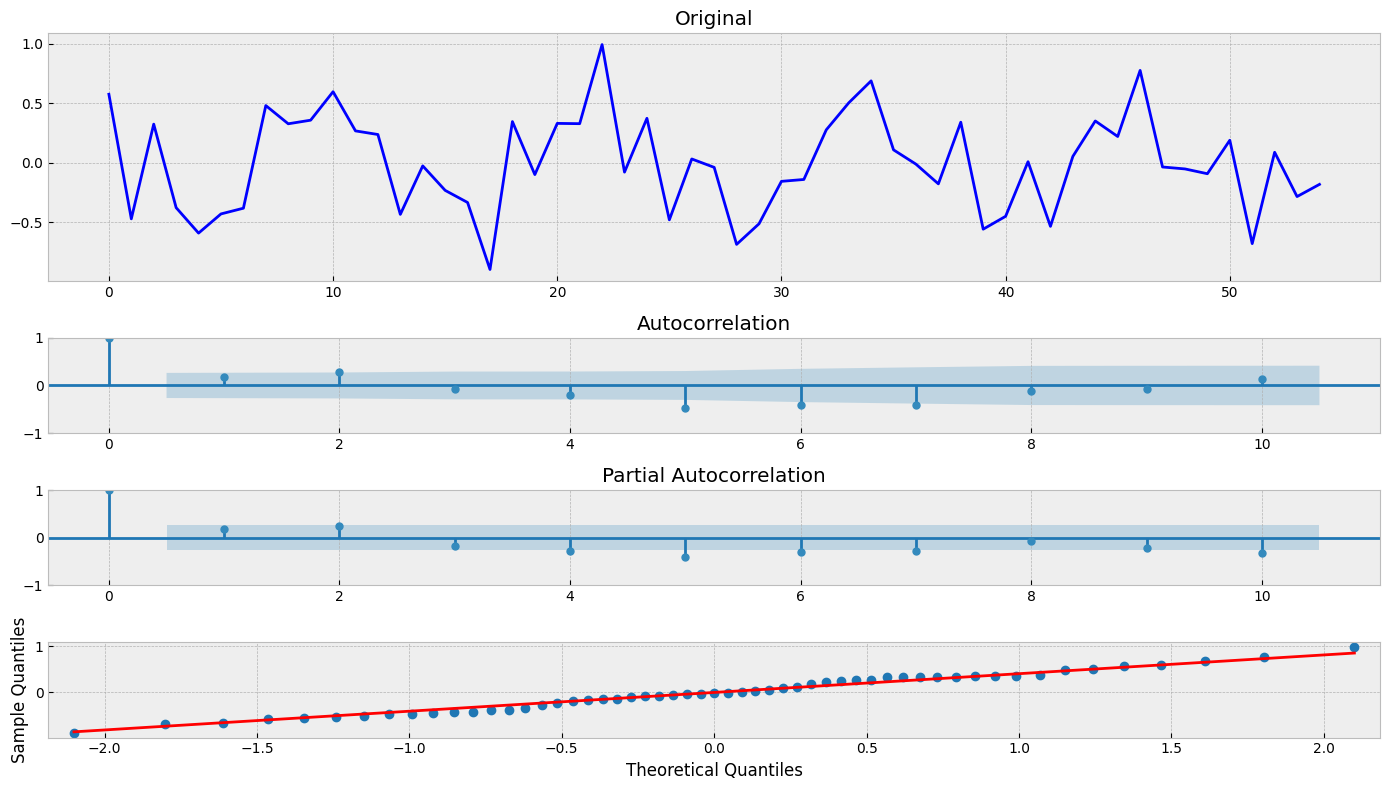

In [343]:
tsplot(mdl.resid, lags=10)

In [344]:
# сделаем предсказания
predict = mdl.predict(start=60, end=100)
predict

array([-0.06733156, -0.05981066, -0.04847713, -0.0435104 , -0.03793557,
       -0.0349567 , -0.03213003, -0.03042491, -0.02896097, -0.02800924,
       -0.02724024, -0.02671661, -0.02630892, -0.02602326, -0.02580585,
       -0.02565079, -0.02553443, -0.02545052, -0.02538809, -0.02534278,
       -0.02530924, -0.02528479, -0.02526676, -0.02525358, -0.02524387,
       -0.02523677, -0.02523155, -0.02522772, -0.02522491, -0.02522285,
       -0.02522134, -0.02522023, -0.02521941, -0.02521881, -0.02521838,
       -0.02521805, -0.02521782, -0.02521764, -0.02521752, -0.02521742,
       -0.02521735])

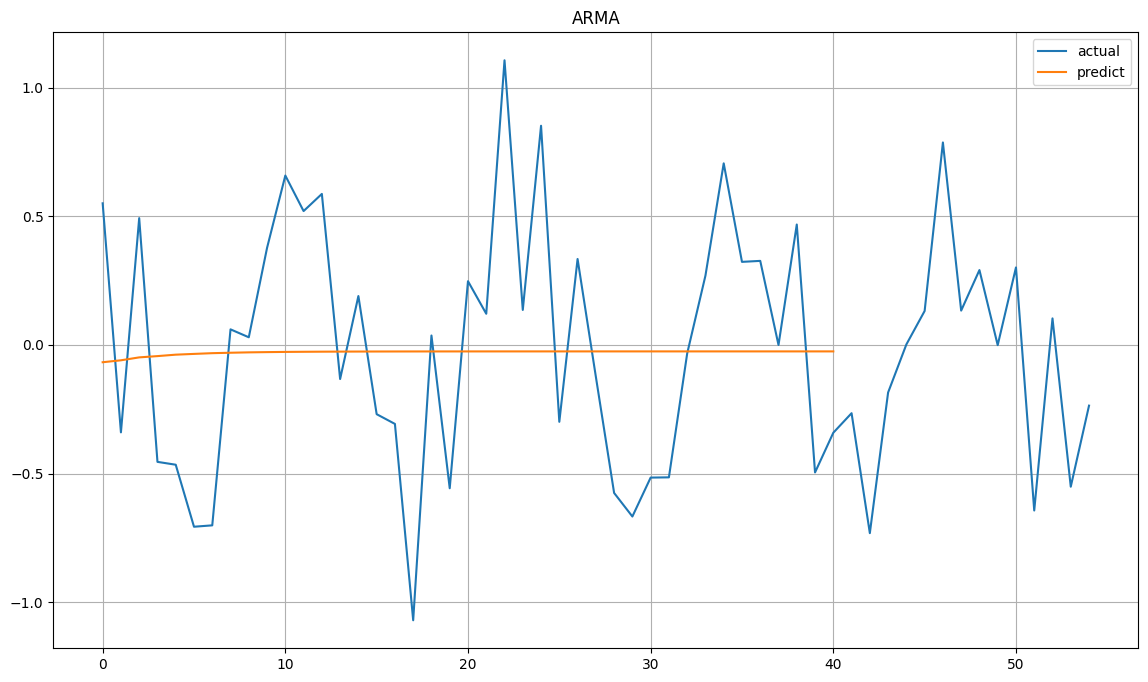

In [345]:
# построим график предсказаний
plt.figure(figsize=(14, 8))
plt.plot(series, label="actual")
plt.plot(predict, label="predict")
plt.legend(loc="best")
plt.title("ARMA")
plt.grid(True);

In [346]:
mdl.aic

65.80728728699117

In [347]:
# реализуем подбор гиперпараметров модели ARMA
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for j in range(5):
        try:
            tmp_mdl = ARIMA(series, order=(2, 0, 0), trend='c').fit()
            tmp_aic = tmp_mdl.aic
            print('aic: {:6.5f} | order: {}'.format(tmp_aic, (i, j)))
            if tmp_aic < best_aic:
                best_aic = tmp_aic
                best_order = (i, j)
                best_mdl = tmp_mdl
        except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))

aic: 65.80729 | order: (0, 0)
aic: 65.80729 | order: (0, 1)
aic: 65.80729 | order: (0, 2)
aic: 65.80729 | order: (0, 3)
aic: 65.80729 | order: (0, 4)
aic: 65.80729 | order: (1, 0)
aic: 65.80729 | order: (1, 1)
aic: 65.80729 | order: (1, 2)
aic: 65.80729 | order: (1, 3)
aic: 65.80729 | order: (1, 4)
aic: 65.80729 | order: (2, 0)
aic: 65.80729 | order: (2, 1)
aic: 65.80729 | order: (2, 2)
aic: 65.80729 | order: (2, 3)
aic: 65.80729 | order: (2, 4)
aic: 65.80729 | order: (3, 0)
aic: 65.80729 | order: (3, 1)
aic: 65.80729 | order: (3, 2)
aic: 65.80729 | order: (3, 3)
aic: 65.80729 | order: (3, 4)
aic: 65.80729 | order: (4, 0)
aic: 65.80729 | order: (4, 1)
aic: 65.80729 | order: (4, 2)
aic: 65.80729 | order: (4, 3)
aic: 65.80729 | order: (4, 4)
aic: 65.80729 | order: (0, 0)


Построим модель ARIMA

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: Conver

aic: 17.11273 | order: (3, 0, 2)
Results of Dickey-Fuller Test:
Test Statistic                -7.663003e+00
p-value                        1.669334e-11
#Lags Used                     0.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


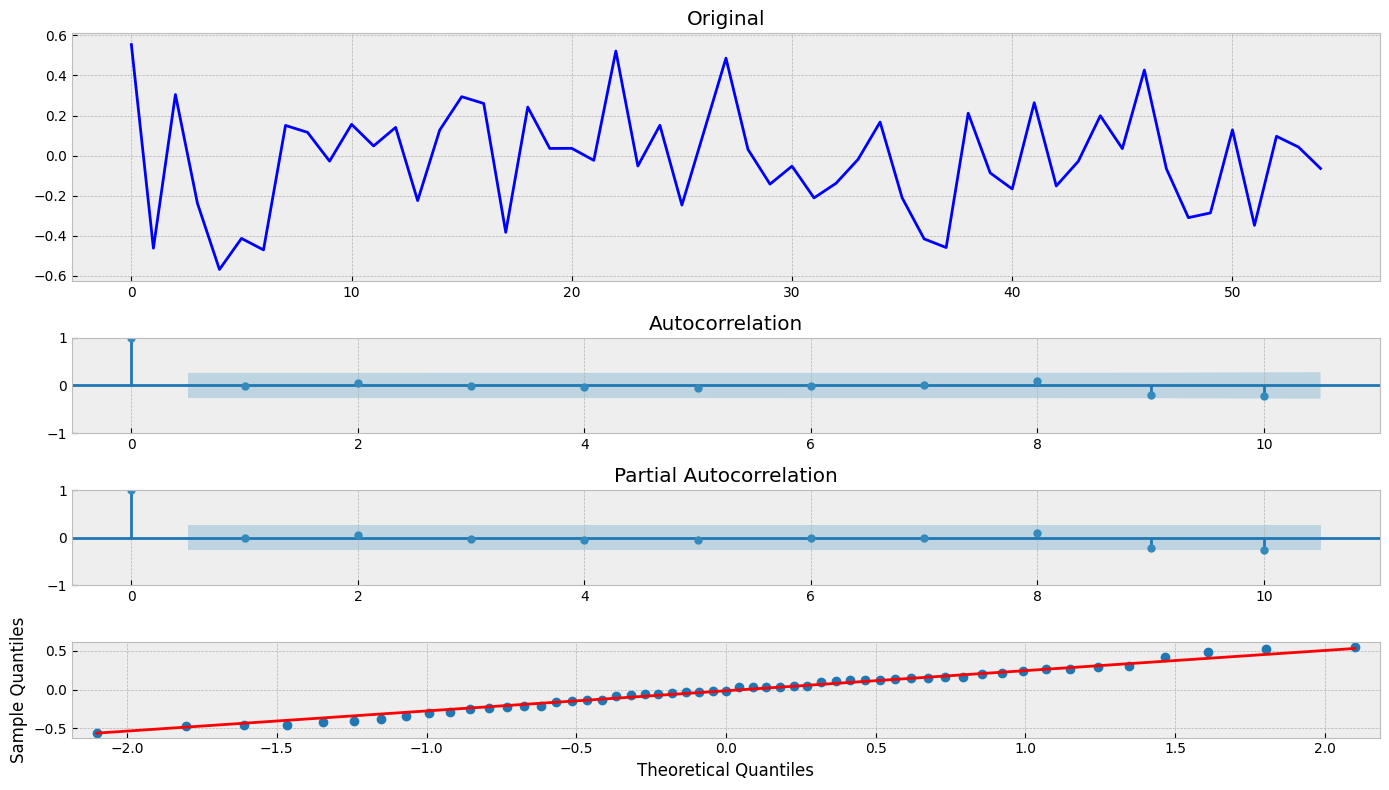

In [348]:
best_aic = np.inf
best_order = None
best_mdl = None

for i in range(5):
    for d in range(5):
        for j in range(5):
            try:
                tmp_mdl = ARIMA(series, order=(i,d,j), trend='c').fit()
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue


print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))


tsplot(best_mdl.resid, lags=10)

In [349]:
best_mdl

In [350]:
# сделаем прогноз
predict = best_mdl.predict(start=60, end=100)

In [351]:
predict

array([ 0.31343521,  0.19973742,  0.04843873, -0.124555  , -0.25906195,
       -0.33027212, -0.31388955, -0.21884642, -0.06773657,  0.09818644,
        0.23688963,  0.31192046,  0.30473896,  0.21751146,  0.07361168,
       -0.08937141, -0.228977  , -0.30923718, -0.30974475, -0.23096463,
       -0.09387627,  0.06555685,  0.20585313,  0.2907818 ,  0.29873111,
        0.22819496,  0.09802433, -0.05760996, -0.19818257, -0.28736548,
       -0.30241305, -0.23996032, -0.11675489,  0.03482912,  0.17529557,
        0.26831523,  0.29011963,  0.23557123,  0.11936058, -0.02794476,
       -0.16793806])

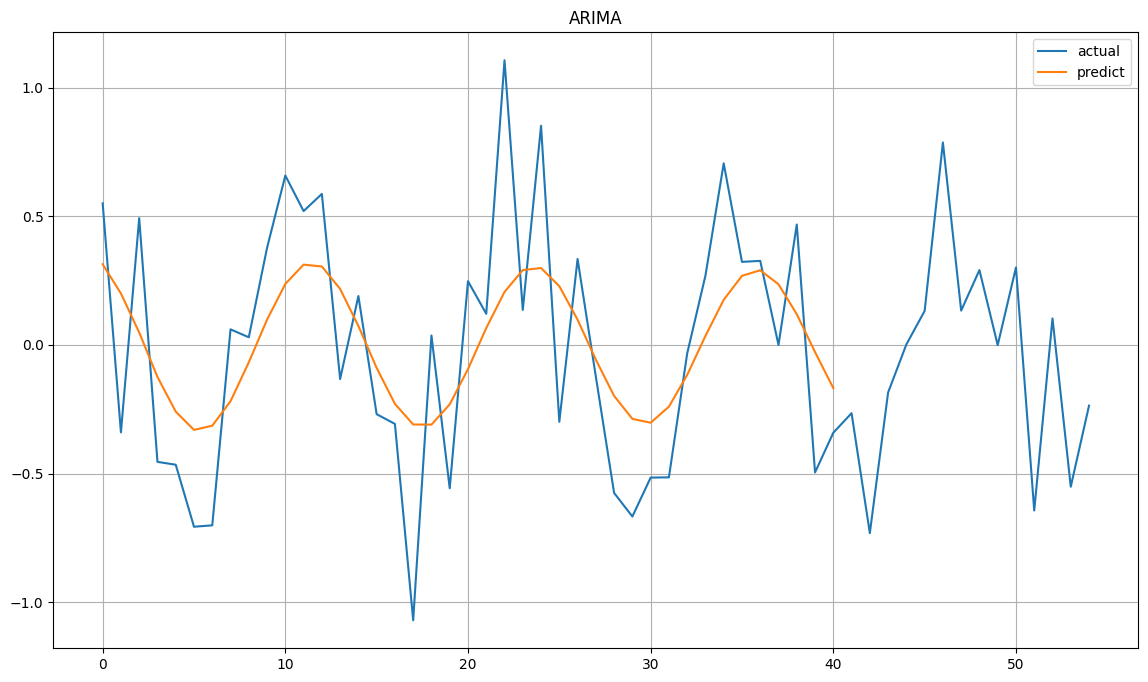

In [365]:
# построим график предсказаний
plt.figure(figsize=(14, 8))
plt.plot(series, label="actual")
plt.plot(predict, label="predict")
plt.legend(loc="best")
plt.title("ARIMA")
plt.grid(True)

Выглядит довольно симпатично

Модель ARCH

In [353]:
def model_arima (series):
  best_aic = np.inf
  best_order = None
  best_mdl = None

  for i in range(5):
      for d in range(5):
          for j in range(5):
              try:
                  tmp_mdl = ARIMA(series, order=(i,d,j))
                  tmp_mdl = tmp_mdl.fit()
                  tmp_aic = tmp_mdl.aic
                  if tmp_aic < best_aic:
                      best_aic = tmp_aic
                      best_order = (i, d, j)
                      best_mdl = tmp_mdl
              except: continue
  return best_order, best_mdl

In [354]:
best_order, best_mdl = model_arima(series)

print(f" Параметры модели: p = {best_order[0]}, d = {best_order[1]}, q = {best_order[2]}.")

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Like

 Параметры модели: p = 3, d = 0, q = 2.


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Results of Dickey-Fuller Test:
Test Statistic                -7.663003e+00
p-value                        1.669334e-11
#Lags Used                     0.000000e+00
Number of Observations Used    5.400000e+01
Critical Value (1%)           -3.557709e+00
Critical Value (5%)           -2.916770e+00
Critical Value (10%)          -2.596222e+00
dtype: float64


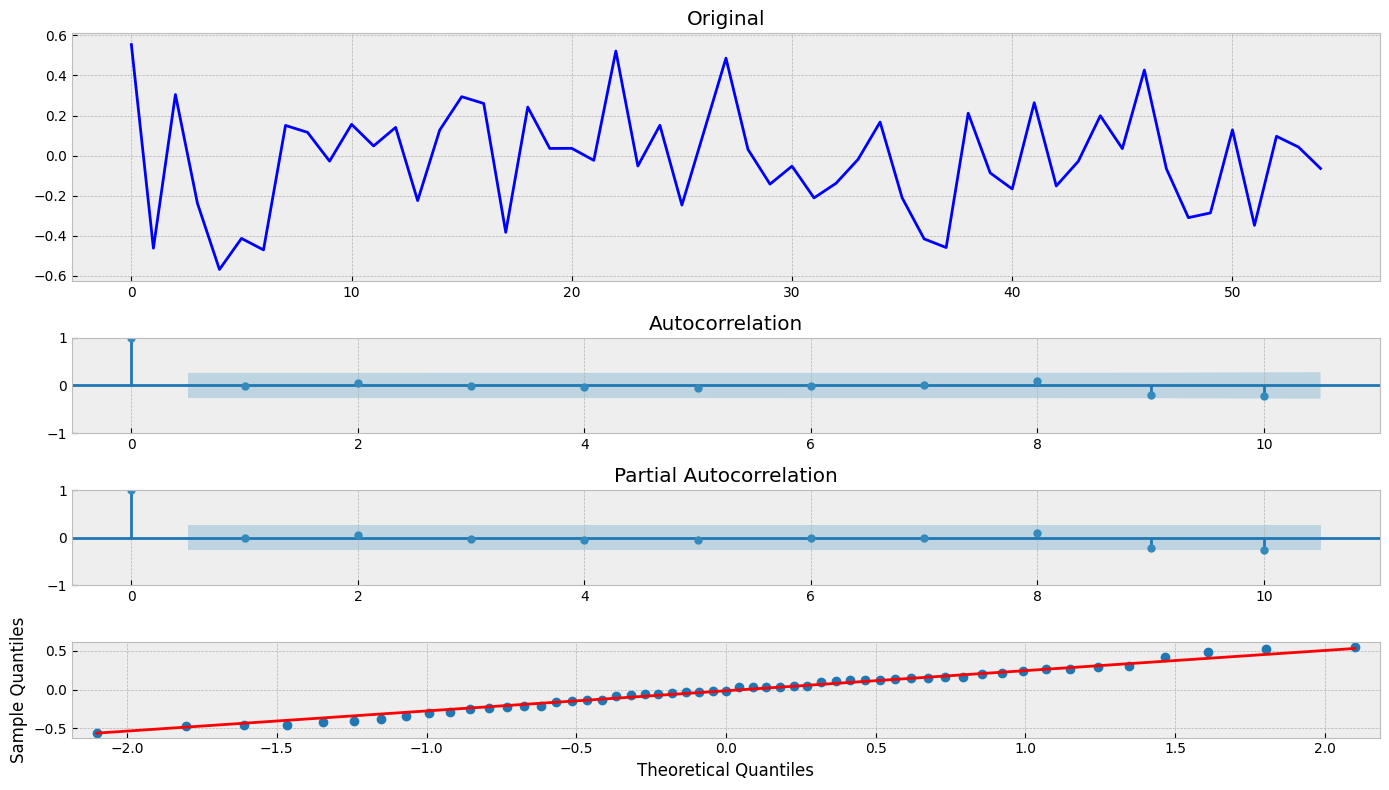

In [358]:
#  построим график остатков

tsplot(best_mdl.resid, lags=10)

In [356]:
# Now we can fit the arch model using the best fit arima model parameters
p_ = best_order[0]
o_ = best_order[1]
q_ = best_order[2]

# Using student T distribution usually provides better fit
am = arch_model(female_births, p=p_, o=o_, q=q_, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                        Count   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1241.87
Distribution:      Standardized Student's t   AIC:                           2499.74
Method:                  Maximum Likelihood   BIC:                           2530.94
                                              No. Observations:                  365
Date:                      Sun, Dec 15 2024   Df Residuals:                      364
Time:                              17:48:08   Df Model:                            1
                               Mean Model                               
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
mu            41

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


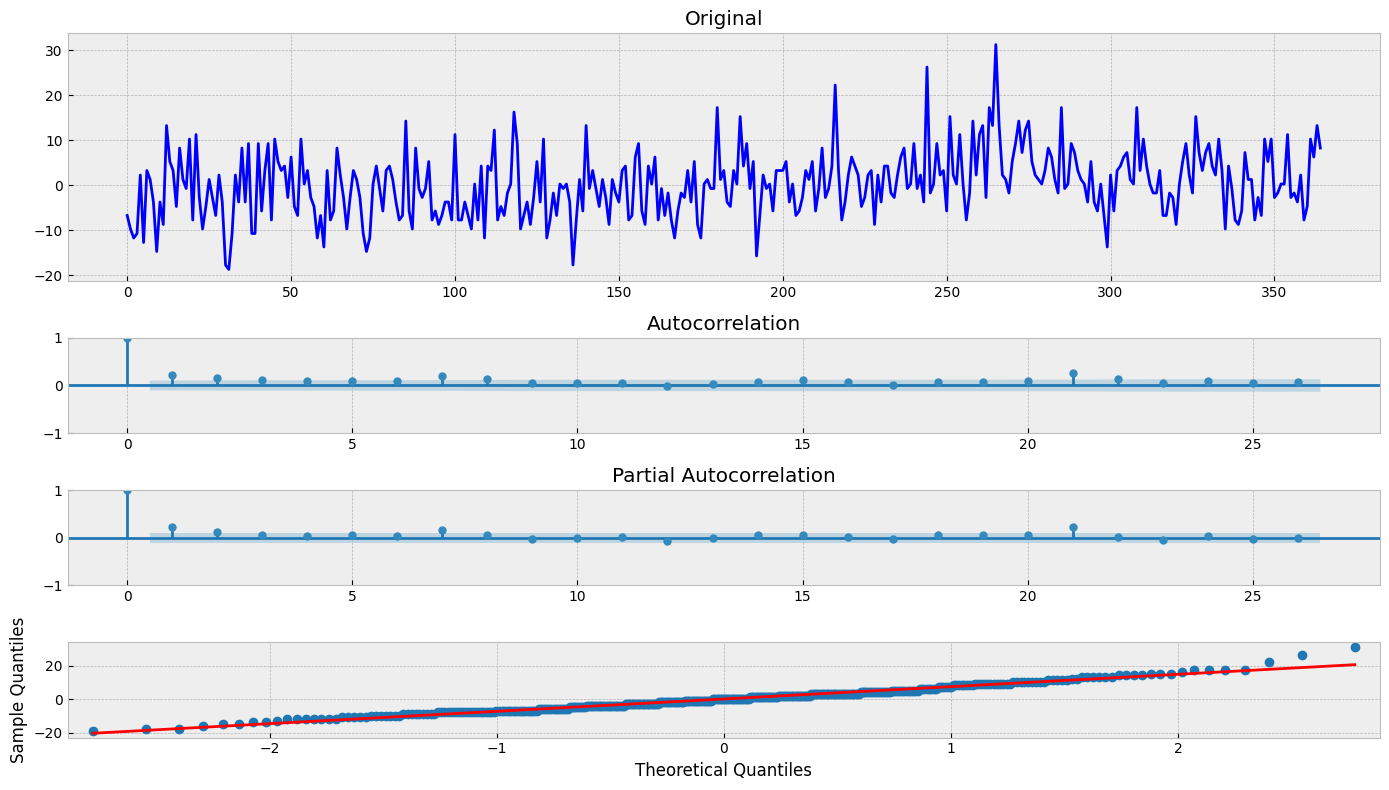

In [357]:
tsplot(res.resid)

In [359]:
# построим модель SARIMAX
SARIMAX_model = sm.tsa.statespace.SARIMAX(series, order=(7,1,7),
                                          seasonal_order=(0,0,0,0),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          trend='c',
                                          m=12).fit()
SARIMAX_model.summary()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['m']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   55
Model:               SARIMAX(7, 1, 7)   Log Likelihood                   7.073
Date:                Sun, 15 Dec 2024   AIC                             17.855
Time:                        17:49:06   BIC                             47.113
Sample:                             0   HQIC                            28.815
                                 - 55                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0037      0.003     -1.089      0.276      -0.010       0.003
ar.L1         -0.2634      0.578     -0.455      0.649      -1.397       0.870
ar.L2         -0.0158      0.828     -0.019      0.985      -1.638       1.607
ar.L3         -0.0189      0.614     -0.031      0.975      -1.222       1.184
ar.L4          0.2618      0.286      0.914      0.361      -0.299       0.823
ar.L5         -0.4101      0.270     -1.521      0.128      -0.939       0.118
ar.L6         -0.6612      0.594     -1.114      0.265      -1.825       0.502
ar.L7         -0.3110      0.473     -0.657      0.511      -1.239       0.617
ma.L1         -1.2694      1.263     -1.005      0.315      -3.744       1.205
ma.L2          0.6801      1.579      0.431      0.667      -2.414       3.774
ma.L3         -0.7094      2.544     -0.279      0.780      -5.696       4.277
ma.L4          0.1180      2.559      0.046      0.963      -4.897       5.133
ma.L5          0.4267      1.945      0.219      0.826      -3.385       4.239
ma.L6          0.2469      0.982      0.251      0.802      -1.678       2.172
ma.L7         -0.4831      0.640     -0.755      0.450      -1.737       0.771
sigma2         0.0352      0.040      0.885      0.376      -0.043       0.113
===================================================================================
Ljung-Box (L1) (Q):                   0.10   Jarque-Bera (JB):                 1.08
Prob(Q):                              0.75   Prob(JB):                         0.58
Heteroskedasticity (H):               1.42   Skew:                             0.26
Prob(H) (two-sided):                  0.50   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Results of Dickey-Fuller Test:
Test Statistic                 -3.079872
p-value                         0.028079
#Lags Used                      7.000000
Number of Observations Used    47.000000
Critical Value (1%)            -3.577848
Critical Value (5%)            -2.925338
Critical Value (10%)           -2.600774
dtype: float64


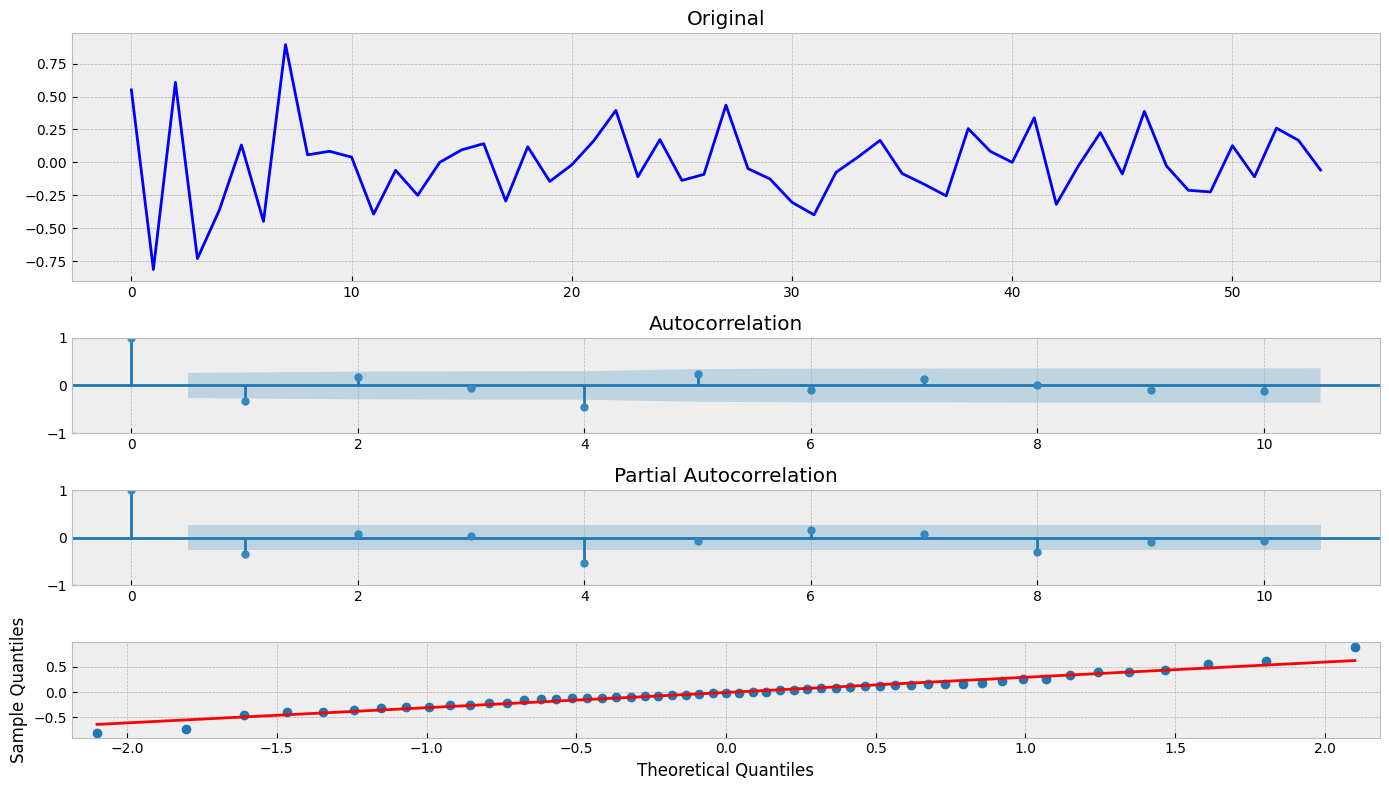

In [360]:
# построим график остатков
tsplot(SARIMAX_model.resid, lags=10)

Cпрогнозируем график классическим ML

In [361]:
X_train, X_test, y_train, y_test = prepareData(sales_of_company_x, lag_start=1, lag_end=20, test_size=0.3)

In [362]:
X_train

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19
0,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0,96.0,154.0
1,169.0,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0,96.0
2,289.0,169.0,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0
3,347.0,289.0,169.0,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0
4,375.0,347.0,289.0,169.0,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0
5,203.0,375.0,347.0,289.0,169.0,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0
6,223.0,203.0,375.0,347.0,289.0,169.0,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0
7,104.0,223.0,203.0,375.0,347.0,289.0,169.0,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0,169.0
8,107.0,104.0,223.0,203.0,375.0,347.0,289.0,169.0,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0,210.0
9,85.0,107.0,104.0,223.0,203.0,375.0,347.0,289.0,169.0,167.0,91.0,78.0,79.0,90.0,118.0,200.0,245.0,298.0,278.0


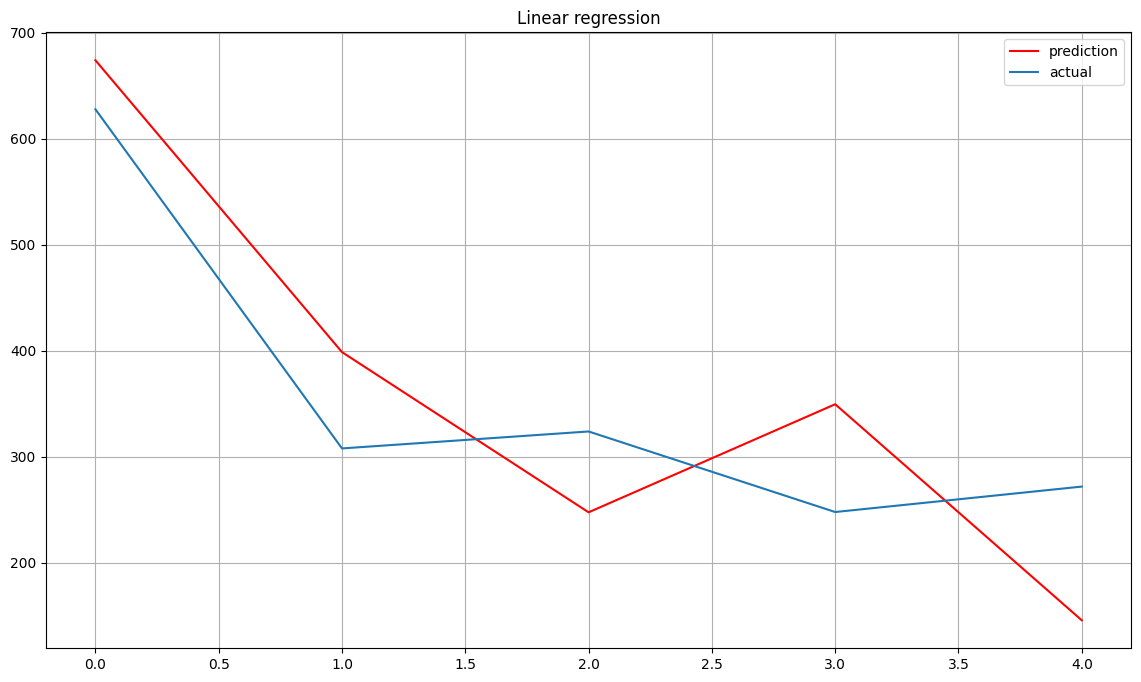

In [363]:
# Строим модель линеной регресии и график предсказания
lr = LinearRegression()
lr.fit(X_train, y_train)
prediction = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid(True);

In [364]:
# оценим качество модели
print(f"MAE: {mean_absolute_error(y_test, prediction)}")
print(f"MAPE: {mean_absolute_percentage_error(y_test, prediction)}")
print(f"MSE: {mean_squared_error(y_test, prediction)}")
print(f"RMSE: {mean_squared_error(y_test, prediction, squared=False)}")
print(f"R2: {r2_score(y_test, prediction)}")
print(f"Explained variance score: {explained_variance_score(y_test, prediction)}")
print(f"Median absolute error: {median_absolute_error(y_test, prediction)}")

MAE: 88.23209159005765
MAPE: 0.29554822297026373
MSE: 8491.606911177627
RMSE: 92.14991541600908
R2: 0.5578761813157267
Explained variance score: 0.560627294727128
Median absolute error: 90.85485234840507


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


В целом качество модели по выбранным параметрам довольно высокое и модель можно использовать для выбранного ряда

Выводы:
1. На примере одного стационарного и одного нестационарного ряда данные были проверены на соответствие моделям случайного блуждания и авторегрессионной модели
2. На примере одного стационарного и одного нестационарного ряда были построены модели ARMA, ARIMA и ARCH
3. Для нестационарного ряда построена дополнительная модель SARIMAX
4. По обоим рядам были построены модели линейной регрессии и выполнена оценка качества моделей
